In [29]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Flatten, Dense, concatenate, Conv2D, MaxPooling2D
from keras.optimizers import Adam
import tensorflow as tf


In [30]:
# Zip file
file_name = "/content/Photos.zip"

# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # extracting all the files
    zip.extractall()

In [31]:
# Load the labels
labels_df = pd.read_csv('/content/CoinData.csv',sep= ';')

# Split the data into training and testing sets
train_df, test_df = train_test_split(labels_df, test_size=0.2, random_state=53)

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
)

# Normalization for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='/content/CoinDrops',
    x_col='image',
    y_col=['X','Y'],
    target_size=(32, 32),
    color_mode='grayscale', # The color doesnt give information about the position
    batch_size=32,
    class_mode='raw',
    shuffle=True
)

# Testing data generator without augmentation
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory='/content/CoinDrops',
    x_col='image',
    y_col=['X','Y'],
    target_size=(32, 32),
    color_mode='grayscale',
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

Found 83 validated image filenames.
Found 21 validated image filenames.


In [32]:
def coordinate_accuracy(y_true, y_pred):
    # Accuracy circle
    return tf.reduce_mean(tf.cast(tf.abs(y_true - y_pred) <= 11.5, tf.float32))

image_input = Input(shape=(32, 32, 1), name='image_input')

# Convolutional layers
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(image_input)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(16, kernel_size=(3, 3), activation='relu')(maxpool1)
maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

# Flatten the image input
flatten_layer = Flatten()(maxpool2)

# Shared dense layers
shared_dense1 = Dense(16, activation='relu')(flatten_layer)

# Regression output X
regression_branch1 = Dense(16, activation='relu')(shared_dense1)
output_regression1 = Dense(1, activation='linear', name='output_regression1')(regression_branch1)

# Another regression Y
regression_branch2 = Dense(16, activation='relu')(shared_dense1)
output_regression2 = Dense(1, activation='linear', name='output_regression2')(regression_branch2)

# Define the model
model = Model(inputs=image_input, outputs=[output_regression1, output_regression2])

# Compile the model
model.compile(optimizer=Adam(lr=0.001),
              loss={'output_regression1': 'mean_squared_error',
                    'output_regression2': 'mean_squared_error',
                    },
              metrics={'output_regression1': coordinate_accuracy,
                       'output_regression2': coordinate_accuracy,
                       })

# Display the model summary
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 30, 30, 32)           320       ['image_input[0][0]']         
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 32)           0         ['conv2d_4[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 13, 13, 16)           4624      ['max_pooling2d_4[0][0]'

In [33]:
# Train the model using fit_generator
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=len(train_generator),
    epochs=25,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

<ipython-input-33-2f1e7346a2aa>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/25
3/3 [==============================] - 3s 490ms/step - loss: 173.4385 - output_regression1_loss: 86.6449 - output_regression2_loss: 86.7936 - output_regression1_coordinate_accuracy: 0.8276 - output_regression2_coordinate_accuracy: 0.8276 - val_loss: 233.6639 - val_output_regression1_loss: 116.7463 - val_output_regression2_loss: 116.9176 - val_output_regression1_coordinate_accuracy: 0.7857 - val_output_regression2_coordinate_accuracy: 0.7857
Epoch 2/25
3/3 [==============================] - 1s 255ms/step - loss: 173.1883 - output_regression1_loss: 86.5388 - output_regression2_loss: 86.6495 - output_regression1_coordinate_accuracy: 0.8383 - output_regression2_coordinate_accuracy: 0.8383 - val_loss: 233.5126 - val_output_regression1_loss: 116.6803 - val_output_regression2_loss: 116.8324 - val_output_regression1_coordinate_accuracy: 0.7857 - val_output_regression2_coordinate_accuracy: 0.7857
Epoch 3/25
3/3 [==============================] - 1s 249ms/step - loss: 173.1037 - outpu

In [34]:
# Evaluate the model on the test set
evaluation = model.evaluate(test_generator, steps=len(test_generator))

# Print the evaluation results
print("Evaluation Results:")
print("X Custom Coordinate Accuracy:", evaluation[3])  # Assuming regression1 custom metric is at index 4
print("Y Custom Coordinate Accuracy:", evaluation[4])  # Assuming regression2 custom metric is at index 5

1/1 [==============================] - 0s 190ms/step - loss: 229.4008 - output_regression1_loss: 113.8077 - output_regression2_loss: 115.5931 - output_regression1_coordinate_accuracy: 0.7857 - output_regression2_coordinate_accuracy: 0.7857
Evaluation Results:
X Custom Coordinate Accuracy: 0.7857142686843872
Y Custom Coordinate Accuracy: 0.7857142686843872


In [12]:
model.metrics_names

['loss',
 'output_regression1_loss',
 'output_regression2_loss',
 'output_regression1_coordinate_accuracy',
 'output_regression2_coordinate_accuracy']

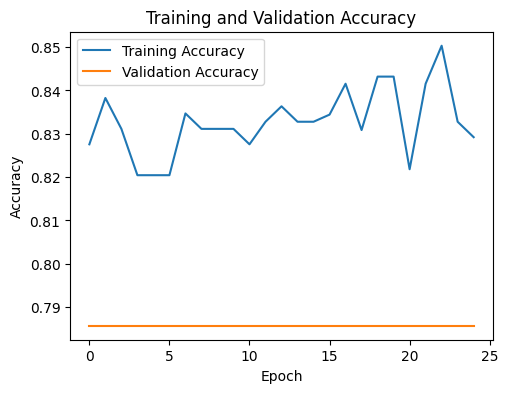

In [35]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['output_regression1_coordinate_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_output_regression1_coordinate_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [36]:
predictions = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

<ipython-input-36-04cc344fc33c>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)


1/1 [==============================] - 0s 407ms/step


In [37]:
X_data = labels_df['X'].to_numpy()
Y_data = labels_df['Y'].to_numpy()

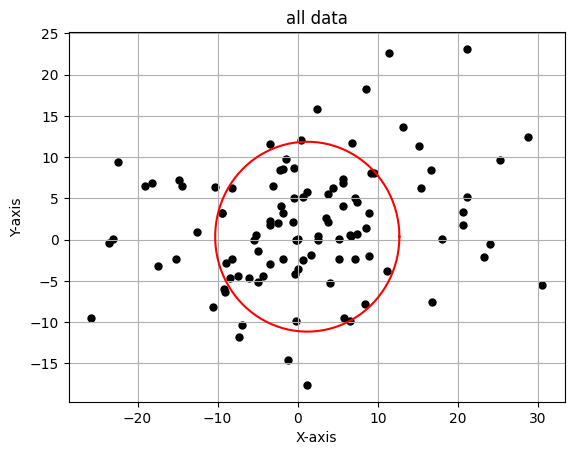

In [39]:
plt.scatter(X_data, Y_data, c="black", s=25)  # 'c' parameter sets the colors, 's' sets marker size
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('all data')
plt.grid(True)

radius = 11.5
center_x = predictions[0][4]
center_y = predictions[1][4]

# Create a circle
theta = np.linspace(0, 2*np.pi, 100)
circle_x = center_x + radius * np.cos(theta)
circle_y = center_y + radius * np.sin(theta)

# Plot the circle
plt.plot(circle_x, circle_y, label='Circle', color='red')

plt.show()